In [ ]:
## Valid the mentioned accuracy on huggingface repo

In [ ]:
# !pip transformers datasets torch scikit-learn

In [6]:
# Load fine-tuned model
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("gokuls/BERT-tiny-emotion-intent")
model = AutoModelForSequenceClassification.from_pretrained("gokuls/BERT-tiny-emotion-intent")

/home/tony/FHE-BERT-Tiny/env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [2]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-1

In [17]:
# Load validation dataset
from datasets import load_dataset

valid_dataset = load_dataset("dair-ai/emotion", split="validation")

In [4]:
print(valid_dataset)
print(valid_dataset[0])

Dataset({
    features: ['text', 'label'],
    num_rows: 2000
})
{'text': 'im feeling quite sad and sorry for myself but ill snap out of it soon', 'label': 0}


In [18]:
from torch.utils.data import DataLoader

# Tokenize the dataset
def tokenize_function(example):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=128)
tokenized_valid_dataset = valid_dataset.map(tokenize_function, batched=True)
tokenized_valid_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Create a dataloader
valid_dataloader = DataLoader(tokenized_valid_dataset, batch_size=32)

In [6]:
# Evaluation
import torch

#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')
model.to(device)

# Store predictions and true labels
predictions = []
true_labels = []

model.eval()
with torch.no_grad():
    for batch in valid_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        logits = logits.detach().cpu()
        label_ids = labels.to('cpu')
        
        # Store predictions and true labels
        predictions.extend(torch.argmax(logits, dim=1).numpy())
        true_labels.extend(label_ids.numpy())

In [7]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Calculate Precision, Recall, F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Generate Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Detailed Classification Report
report = classification_report(true_labels, predictions, target_names=valid_dataset.features['label'].names)
print("Classification Report:")
print(report)

Accuracy: 0.9100
Precision: 0.9117
Recall:    0.9100
F1-Score:  0.9102
Confusion Matrix:
[[516  12   3  10   7   2]
 [ 12 655  24   2   3   8]
 [  1  19 155   3   0   0]
 [ 13   4   1 253   4   0]
 [ 16   3   0   7 170  16]
 [  1   4   1   1   3  71]]
Classification Report:
              precision    recall  f1-score   support

     sadness       0.92      0.94      0.93       550
         joy       0.94      0.93      0.94       704
        love       0.84      0.87      0.86       178
       anger       0.92      0.92      0.92       275
        fear       0.91      0.80      0.85       212
    surprise       0.73      0.88      0.80        81

    accuracy                           0.91      2000
   macro avg       0.88      0.89      0.88      2000
weighted avg       0.91      0.91      0.91      2000



In [11]:
# Result matched

In [ ]:
## Record the mean & inverse variance of each LayerNorm for further pre-compute LayerNorm computation

In [8]:
# Load train dataset
train_dataset = load_dataset("dair-ai/emotion", split="train")

print(train_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})


In [10]:
from torch.utils.data import DataLoader

# Tokenize the dataset
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Create a dataloader
train_dataloader = DataLoader(tokenized_train_dataset, batch_size=32)

In [11]:
# Create a dictionary to store LayerNorm Inputs
layernorm_inputs = {
    'layer0_self_output': [],
    'layer0_output': [],
    'layer1_self_output': [],
    'layer1_output': []
}

# Hook function to capture the inputs from each LayerNorm layer
def get_layernorm_input(layer):
    def hook(module, input):
        layernorm_inputs[layer].append(input[0].detach().cpu())
    return hook
layer0_self_output_hook = model.bert.encoder.layer[0].attention.output.LayerNorm.register_forward_pre_hook(
    get_layernorm_input('layer0_self_output')
)
layer0_output_hook = model.bert.encoder.layer[0].output.LayerNorm.register_forward_pre_hook(
    get_layernorm_input('layer0_output')
)
layer1_self_output_hook = model.bert.encoder.layer[1].attention.output.LayerNorm.register_forward_pre_hook(
    get_layernorm_input('layer1_self_output')
)
layer1_output_hook = model.bert.encoder.layer[1].output.LayerNorm.register_forward_pre_hook(
    get_layernorm_input('layer1_output')
)

In [12]:
from tqdm import tqdm

# Process
attention_mask_list = [] # to excludle padding tokens
with torch.no_grad():
    for batch in tqdm(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        attention_mask_list.append(attention_mask.detach())

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

# Clean the hooks
layer0_self_output_hook.remove()
layer0_output_hook.remove()
layer1_self_output_hook.remove()
layer1_output_hook.remove()

100%|███████████████████████████████████████| 500/500 [00:11<00:00, 45.27it/s]


In [13]:
import os
import numpy as np

# to excludle padding tokens
all_attention_masks = torch.cat(attention_mask_list, dim=0)
all_attention_masks = all_attention_masks.view(-1)

# Compute the mean & inverse sqrt variance for each LayerNorm layer
for layer, input_list in layernorm_inputs.items():
    # concatenate all inputs for the current layer
    all_inputs = torch.cat(input_list, dim=0)

    # flatten the inputs to merge batch and sequence dimensions
    total_samples, seq_length, hidden_size = all_inputs.shape
    all_inputs = all_inputs.view(-1, hidden_size)

    # exclude padding tokens
    valid_indices = all_attention_masks.nonzero(as_tuple=False).squeeze()
    valid_inputs = all_inputs[valid_indices]

    # Compute mean and variance across all tokens and samples for each feature
    mean = valid_inputs.mean(dim=0)
    var = valid_inputs.var(dim=0, unbiased=False)

    # Compute the inverse square root of variance + epsilon
    epsilon = 1e-12
    inv_sqrt_var = 1.0 / torch.sqrt(var + epsilon)

    #
    path = "./precomputed_layernorm"
    if not (os.path.exists(path)):
        os.makedirs(path)
    # Save the means & inverse sqrt variance to text files
    np.savetxt(f"./{path}/{layer}_mean.txt", mean.numpy())
    np.savetxt(f"./{path}/{layer}_inv_sqrt_var.txt", inv_sqrt_var.numpy())

print("completed.")

completed.


In [ ]:
## Evaluate the pre-computed LayerNorm performance

In [10]:
path = "./precomputed_layernorm"

# Load precomputed means and variances
mean_0_0 = np.loadtxt(f"{path}/layer0_self_output_mean.txt")
inv_sqrt_var_0_0 = np.loadtxt(f"{path}/layer0_self_output_inv_sqrt_var.txt")

mean_0_1 = np.loadtxt(f"{path}/layer0_output_mean.txt")
inv_sqrt_var_0_1 = np.loadtxt(f"{path}/layer0_output_inv_sqrt_var.txt")

mean_1_0 = np.loadtxt(f"{path}/layer1_self_output_mean.txt")
inv_sqrt_var_1_0 = np.loadtxt(f"{path}/layer1_self_output_inv_sqrt_var.txt")

mean_1_1 = np.loadtxt(f"{path}/layer1_output_mean.txt")
inv_sqrt_var_1_1 = np.loadtxt(f"{path}/layer1_output_inv_sqrt_var.txt")

#print("mean_0_0: ", mean_0_0)

In [11]:
from datasets import load_dataset

# the author used validation dataset to test the performance
# I use test dataset
test_dataset = load_dataset("dair-ai/emotion", split="test")
print(test_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 2000
})


In [17]:
correct_plain = 0
correct_precomp = 0

for ind in range(len(test_dataset)):
    text = "[CLS] " + test_dataset['text'][ind] + " [SEP]"

    tokenized = tokenizer(text)
    tokenized_text = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])

    x = model.bert.embeddings(tokens_tensor, torch.tensor([[1] * len(tokenized_text)]))

    key = model.bert.encoder.layer[0].attention.self.key.weight.clone().detach().double().transpose(0, 1)
    query = model.bert.encoder.layer[0].attention.self.query.weight.clone().detach().double().transpose(0, 1)
    value = model.bert.encoder.layer[0].attention.self.value.weight.clone().detach().double().transpose(0, 1)

    key_bias = model.bert.encoder.layer[0].attention.self.key.bias.clone().detach().double()
    query_bias = model.bert.encoder.layer[0].attention.self.query.bias.clone().detach().double()
    value_bias = model.bert.encoder.layer[0].attention.self.value.bias.clone().detach().double()

    original_input_tensor = x.double()

    input_tensor = x.double()

    q = torch.matmul(input_tensor, query) + query_bias
    k = torch.matmul(input_tensor, key) + key_bias
    v = torch.matmul(input_tensor, value) + value_bias

    q = q.reshape([1, input_tensor.size()[1], 2, 64])
    k = k.reshape([1, input_tensor.size()[1], 2, 64])
    v = v.reshape([1, input_tensor.size()[1], 2, 64])

    q = q.permute([0, 2, 1, 3])
    k = k.permute([0, 2, 3, 1])

    qk = torch.matmul(q, k)
    qk = qk / 8

    qk_softmaxed = torch.softmax(qk, -1)

    v = v.permute([0, 2, 1, 3])

    fin = torch.matmul(qk_softmaxed, v)
    fin = fin.permute([0, 2, 1, 3])
    fin = fin.reshape([1, input_tensor.size()[1], 128])

    mean = mean_0_0
    var = inv_sqrt_var_0_0

    w_output_dense = model.bert.encoder.layer[0].attention.output.dense.weight.clone().detach().double().transpose(0, 1)
    b_output_dense = model.bert.encoder.layer[0].attention.output.dense.bias.clone().detach().double()

    fin2 = torch.matmul(fin, w_output_dense) + b_output_dense
    fin2_backup = fin2.clone()
    fin2_backup = fin2_backup + original_input_tensor

    fin3_whole = []

    for i in range(len(original_input_tensor.squeeze())):
        fin2 = fin2_backup.squeeze()[i]

        idx = i

        if i > len(mean) - 1:
            idx = len(mean) - 1

        fin3_corr = (fin2.squeeze().detach() - mean[idx]) * var[idx]

        w_output_layernorm = model.bert.encoder.layer[0].attention.output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[0].attention.output.LayerNorm.bias.clone().detach().double()

        fin3_corr = fin3_corr * w_output_layernorm + b_output_layernorm
        fin3_whole.append(fin3_corr.detach())

    fin3_whole = torch.cat(tuple(fin3_whole), 0).unsqueeze(0)
    fin_4 = torch.matmul(fin3_whole, model.bert.encoder.layer[0].intermediate.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[0].intermediate.dense.bias

    fin_5 = torch.nn.functional.gelu(fin_4)
    fin_6 = torch.matmul(fin_5, model.bert.encoder.layer[0].output.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[0].output.dense.bias
    fin_6 = fin_6 + fin3_whole

    mean = mean_0_1
    var = inv_sqrt_var_0_1

    fin7_whole = []

    for i in range(len(input_tensor.squeeze())):
        fin_7 = fin_6.squeeze()[i]

        idx = i

        if i > len(mean) - 1:
            idx = len(mean) - 1

        fin7_corr = (fin_7.squeeze().detach() - mean[idx]) * var[idx]

        w_output_layernorm = model.bert.encoder.layer[0].output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[0].output.LayerNorm.bias.clone().detach().double()

        fin7_corr = fin7_corr * w_output_layernorm + b_output_layernorm

        fin7_whole.append(fin7_corr.detach())

    fin7_whole = torch.cat(tuple(fin7_whole), 0).unsqueeze(0)

    key = model.bert.encoder.layer[1].attention.self.key.weight.clone().detach().double().transpose(0, 1)
    query = model.bert.encoder.layer[1].attention.self.query.weight.clone().detach().double().transpose(0, 1)
    value = model.bert.encoder.layer[1].attention.self.value.weight.clone().detach().double().transpose(0, 1)

    key_bias = model.bert.encoder.layer[1].attention.self.key.bias.clone().detach().double()
    query_bias = model.bert.encoder.layer[1].attention.self.query.bias.clone().detach().double()
    value_bias = model.bert.encoder.layer[1].attention.self.value.bias.clone().detach().double()

    original_input_tensor = fin7_whole
    input_tensor = fin7_whole

    q = torch.matmul(input_tensor, query) + query_bias
    k = torch.matmul(input_tensor, key) + key_bias
    v = torch.matmul(input_tensor, value) + value_bias

    q = q.reshape([1, input_tensor.size()[1], 2, 64])
    k = k.reshape([1, input_tensor.size()[1], 2, 64])
    v = v.reshape([1, input_tensor.size()[1], 2, 64])

    q = q.permute([0, 2, 1, 3])
    k = k.permute([0, 2, 3, 1])

    qk = torch.matmul(q, k)
    qk = qk / 8

    qk_softmaxed = torch.softmax(qk, -1)

    v = v.permute([0, 2, 1, 3])

    fin = torch.matmul(qk_softmaxed, v)
    fin = fin.permute([0, 2, 1, 3])
    fin = fin.reshape([1, input_tensor.size()[1], 128])

    mean = mean_1_0
    var = inv_sqrt_var_1_0

    w_output_dense = model.bert.encoder.layer[1].attention.output.dense.weight.clone().detach().double().transpose(0, 1)
    b_output_dense = model.bert.encoder.layer[1].attention.output.dense.bias.clone().detach().double()

    fin2 = torch.matmul(fin, w_output_dense) + b_output_dense
    fin2_backup = fin2.clone()
    fin2_backup = fin2_backup + original_input_tensor

    fin3_whole = []

    for i in range(len(original_input_tensor.squeeze())):
        fin2 = fin2_backup.squeeze()[i]

        idx = i

        if i > len(mean) - 1:
            idx = len(mean) - 1

        fin3_corr = (fin2.squeeze().detach() - mean[idx]) * var[idx]

        w_output_layernorm = model.bert.encoder.layer[1].attention.output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[1].attention.output.LayerNorm.bias.clone().detach().double()

        fin3_corr = fin3_corr * w_output_layernorm + b_output_layernorm
        fin3_whole.append(fin3_corr.detach())

    fin3_whole = torch.cat(tuple(fin3_whole), 0).unsqueeze(0)
    fin_4 = torch.matmul(fin3_whole, model.bert.encoder.layer[1].intermediate.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[1].intermediate.dense.bias

    fin_5 = torch.nn.functional.gelu(fin_4)

    fin_6 = torch.matmul(fin_5, model.bert.encoder.layer[1].output.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[1].output.dense.bias
    fin_6 = fin_6 + fin3_whole

    fin7_whole = []

    mean = mean_1_1
    var = inv_sqrt_var_1_1

    for i in range(len(input_tensor.squeeze())):
        fin_7 = fin_6.squeeze()[i]

        idx = i

        if i > len(mean) - 1:
            idx = len(mean) - 1

        fin7_corr = (fin_7.squeeze().detach() - mean[idx]) * var[idx]

        w_output_layernorm = model.bert.encoder.layer[1].output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[1].output.LayerNorm.bias.clone().detach().double()

        fin7_corr = fin7_corr * w_output_layernorm + b_output_layernorm

        fin7_whole.append(fin7_corr.detach())

    fin7_whole = torch.cat(tuple(fin7_whole), 0).unsqueeze(0)

    densed_pooler = torch.tanh(torch.matmul(fin7_whole.double(), model.bert.pooler.dense.weight.transpose(0, 1).double()) + model.bert.pooler.dense.bias)

    approx = densed_pooler[0][0].detach()
    precise = model.bert.pooler(model.bert.encoder(x)[0]).detach()[0]

    output = torch.matmul(approx, model.classifier.weight.transpose(0, 1).double()) + model.classifier.bias.double()
    output_real = model(tokens_tensor, torch.tensor([[1] * len(tokenized_text)])).logits[0].detach()

    # Multi-labels
    predicted = torch.argmax(output).item()
    predicted_real = torch.argmax(output_real).item()

    if predicted_real == test_dataset['label'][ind]:
      correct_plain += 1

    if predicted == test_dataset['label'][ind]:
      correct_precomp += 1

    """if output_real[0].item() > output_real[1].item() and test_dataset['label'][ind] == 0:
        correct_plain = correct_plain + 1
    if output_real[0].item() < output_real[1].item() and test_dataset['label'][ind] == 1:
        correct_plain = correct_plain + 1

    if output[0].item() > output[1].item() and test_dataset['label'][ind] == 0:
        correct_precomp = correct_precomp + 1
    if output[0].item() < output[1].item() and test_dataset['label'][ind] == 1:
        correct_precomp = correct_precomp + 1"""

accuracy_plain = float(correct_plain) / len(test_dataset['label'])
accuracy_precomp = float(correct_precomp) / len(test_dataset['label'])

print("Accuracy plain: {}\nAccuracy precom: {}".format(accuracy_plain, accuracy_precomp))

print("Performance loss: {}".format(1 - accuracy_precomp / accuracy_plain))

Accuracy plain: 0.902
Accuracy precom: 0.842
Performance loss: 0.0665188470066519


In [ ]:
# Acceptable result

In [ ]:
## Chebyshev Intervals

In [9]:
def precision(correct, approx):
    if type(approx) == list:
        approx = np.array(approx)
    absolute = sum(abs(correct - approx))/len(correct)
    relative = absolute / (sum(abs(correct))/len(correct))
    return 1 - relative

def softmax_contribuisci(x, index = 1):
    if index == 1:
        input_exp_1.append(torch.max(x).item())
        input_exp_1.append(torch.min(x).item())
    else:
        input_exp_2.append(torch.max(x).item())
        input_exp_2.append(torch.min(x).item())

    for head in x.squeeze():
        for row in head:
            if index == 1:
                input_inv_1.append(torch.sum(torch.exp(row)).item())
            else:
                input_inv_2.append(torch.sum(torch.exp(row)).item())

    return torch.softmax(x, -1)

In [47]:
input_exp_1 = []
input_inv_1 = []
input_gelu_1 = np.array([])
input_exp_2 = []
input_inv_2 = []
input_gelu_2 = np.array([])
input_tanh = np.array([])

fhe_correct = 0
fhe_wrong = 0

fhe_accuracy = 0
std_accuracy = 0

for ind in tqdm(range(len(test_dataset))):
    text = "[CLS] " + test_dataset['text'][ind] + " [SEP]"

    tokenized = tokenizer(text)
    tokenized_text = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
        
    x = model.bert.embeddings(tokens_tensor, torch.tensor([[1] * len(tokenized_text)]))

    key = model.bert.encoder.layer[0].attention.self.key.weight.clone().detach().double().transpose(0, 1)
    query = model.bert.encoder.layer[0].attention.self.query.weight.clone().detach().double().transpose(0, 1)
    value = model.bert.encoder.layer[0].attention.self.value.weight.clone().detach().double().transpose(0, 1)

    key_bias = model.bert.encoder.layer[0].attention.self.key.bias.clone().detach().double()
    query_bias = model.bert.encoder.layer[0].attention.self.query.bias.clone().detach().double()
    value_bias = model.bert.encoder.layer[0].attention.self.value.bias.clone().detach().double()

    original_input_tensor = x.double()

    input_tensor = x.double()

    q = torch.matmul(input_tensor, query) + query_bias
    k = torch.matmul(input_tensor, key) + key_bias
    v = torch.matmul(input_tensor, value) + value_bias

    q = q.reshape([1, input_tensor.size()[1], 2, 64])
    k = k.reshape([1, input_tensor.size()[1], 2, 64])
    v = v.reshape([1, input_tensor.size()[1], 2, 64])

    q = q.permute([0, 2, 1, 3])
    k = k.permute([0, 2, 3, 1])

    qk = torch.matmul(q, k)
    qk = qk / 8

    qk_softmaxed = softmax_contribuisci(qk)

    v = v.permute([0, 2, 1, 3])

    fin = torch.matmul(qk_softmaxed, v)
    fin = fin.permute([0, 2, 1, 3])
    fin = fin.reshape([1, input_tensor.size()[1], 128])
    
    #mean = np.array([-0.03383045433490704, -0.04689138747464171, -0.04320052751297194, -0.04194874763842685, -0.03849735236740709, -0.03583471496309556, -0.036673685450259945, -0.03533623114666153, -0.03301200050649906, -0.03385619903604035, -0.03394064677150061, -0.03581378040060232, -0.04000193681582013, -0.042994980738727644, -0.042689484809151766, -0.0422699887342667, -0.040702211423783496, -0.043257636922742766, -0.040924377288572664, -0.04212762593354266, -0.040090620729304687, -0.03727317047412721, -0.030603299343800818, -0.034141189654495016, -0.03468711091296442, -0.032307857857310274, -0.02926372943560165, -0.031292906450152466, -0.037837883896213766, -0.03745859562807607, -0.03794657692710982, -0.03860214509229593, -0.036185650111238955, -0.039154371235979875, -0.03589729976884486, -0.031731895884233016, -0.03465287223481833, -0.031348414682812194, -0.03688161652969029, -0.03338290816163936, -0.038240660222183975, -0.037525466450406116, -0.038229222217722264, -0.041201914113547705, -0.04212576296359885, -0.03980083151775188, -0.04072657806877826, -0.040145599490268025, -0.036685242667777444, -0.034109016054392725, -0.03544325775104831, -0.03623692053970561, -0.04948334692050963, -0.04596823422981405, -0.04892271117435003])
    #var = np.array([0.7495962428549272, 0.6109555428467895, 0.6225590467577651, 0.62495153067201, 0.631395549935461, 0.634492711694546, 0.644892789064359, 0.6542099965205022, 0.6595559062153842, 0.6659906881037033, 0.6680168012366937, 0.6758412527257586, 0.6668118068796066, 0.6718192460326265, 0.67786737736941, 0.6808577853930836, 0.6736657333151266, 0.6676446046843724, 0.6659979061989304, 0.6743226078654423, 0.681388263935704, 0.6837117808950258, 0.6907147768934253, 0.684537831509984, 0.6896744328697597, 0.6916627127801457, 0.6954043965468235, 0.6954046755145293, 0.7001025287354249, 0.695094327647078, 0.6854203403085795, 0.7027792682295838, 0.6956849098218769, 0.6945153573872891, 0.6856697060013522, 0.6897353511373785, 0.700668908202082, 0.6965624918742969, 0.7082690699456209, 0.7043163331126293, 0.7070770512949652, 0.7042510307314358, 0.6978925459183357, 0.7205035876616076, 0.6902461198740245, 0.686971254827903, 0.7028843270104062, 0.7032880792671149, 0.7057843340136714, 0.7104860015626775, 0.7321738164781159, 0.71095817492914, 0.7401485084476891, 0.7312957890728539, 0.7375994654874705])
    mean = mean_0_0
    var = inv_sqrt_var_0_0
    
    
    w_output_dense = model.bert.encoder.layer[0].attention.output.dense.weight.clone().detach().double().transpose(0, 1)
    b_output_dense = model.bert.encoder.layer[0].attention.output.dense.bias.clone().detach().double()

    fin2 = torch.matmul(fin, w_output_dense) + b_output_dense
    fin2_backup = fin2.clone()
    fin2_backup = fin2_backup + original_input_tensor

    fin3_whole = []

    for i in range(len(original_input_tensor.squeeze())):
        fin2 = fin2_backup.squeeze()[i]
        fin3_corr = (fin2.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[0].attention.output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[0].attention.output.LayerNorm.bias.clone().detach().double()

        fin3_corr = fin3_corr * w_output_layernorm + b_output_layernorm
        fin3_whole.append(fin3_corr.detach())

    fin3_whole = torch.cat(tuple(fin3_whole), 0).unsqueeze(0)
    fin_4 = torch.matmul(fin3_whole, model.bert.encoder.layer[0].intermediate.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[0].intermediate.dense.bias

    input_gelu_1 = np.append(input_gelu_1, fin_4.reshape(-1).detach().numpy())
    
    fin_5 = torch.nn.functional.gelu(fin_4)
    fin_6 = torch.matmul(fin_5, model.bert.encoder.layer[0].output.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[0].output.dense.bias
    fin_6 = fin_6 + fin3_whole
    
    #mean = np.array([-0.09545516102868973, 0.034540955180462664, 0.03934738149667437, 0.040802318439555035, 0.04426037798445811, 0.04919343175846099, 0.0493616301294401, 0.047896279398118795, 0.04912640635535303, 0.048717249992826256, 0.0477219385203478, 0.05095357678578503, 0.05094908370417657, 0.0493275745992752, 0.048418324664654545, 0.0473653504669205, 0.04528009986283869, 0.04524247257539856, 0.046555073355952846, 0.0516135997743503, 0.049103903254210594, 0.048877585502238356, 0.048364988370661784, 0.049043507301742846, 0.049933470462367846, 0.05175179126331398, 0.05057227793143223, 0.055763206569478994, 0.055243365455213404, 0.04986745821758072, 0.047789218698650125, 0.047852162700887234, 0.04279460740337753, 0.04280733225675328, 0.04644169155736491, 0.04783492130826333, 0.04759649093761958, 0.045252139153821, 0.04367184005341422, 0.039034762655413016, 0.04374965234639466, 0.04355128435775863, 0.04499861862695065, 0.04318602336450084, 0.04549296197766528, 0.03907804279518851, 0.037683132925437485, 0.04109696491189214, 0.04410155617431274, 0.05015992918511731, 0.04335430986396108, 0.046492484403760526, 0.044277581701870204, 0.03723061917091777, 0.039156973130334664])
    #var = np.array([0.4156698594967092, 0.7008452266859936, 0.7214270983257646, 0.7095727482866087, 0.7102521835201318, 0.710293676073547, 0.7091783271698753, 0.6973493176419543, 0.7011688527520855, 0.7007704875343309, 0.6950537183089973, 0.6948029158092094, 0.6919309911197036, 0.6933694537037308, 0.6970711644923971, 0.7004276850010867, 0.6964234913676165, 0.6987678419874651, 0.6951829293138483, 0.6973048809142951, 0.6989420799277399, 0.7005696487948311, 0.6993937733493811, 0.6902070532566239, 0.6958399824203775, 0.6900361005407983, 0.6925891359742274, 0.6831642926666377, 0.6865279710039072, 0.6904370385593245, 0.6963724536275457, 0.6948942601360332, 0.6784634186071326, 0.6759657478656234, 0.6828578884489792, 0.683566347862741, 0.6857777074044566, 0.672040915409448, 0.6784995422914343, 0.6732453264186854, 0.683881765911935, 0.6909411690410042, 0.6715428435769978, 0.6775867807314924, 0.6785015863916147, 0.676156117696202, 0.6786376609996214, 0.6763771062984715, 0.7119440584663215, 0.7070342067744777, 0.6895996022331654, 0.6683970656272868, 0.6695013664908844, 0.6566575067124804, 0.672887703816164])
    mean = mean_0_1
    var = inv_sqrt_var_0_1
    
    fin7_whole = []

    for i in range(len(input_tensor.squeeze())):
        fin_7 = fin_6.squeeze()[i]

        fin7_corr = (fin_7.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[0].output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[0].output.LayerNorm.bias.clone().detach().double()

        fin7_corr = fin7_corr * w_output_layernorm + b_output_layernorm

        fin7_whole.append(fin7_corr.detach())

    fin7_whole = torch.cat(tuple(fin7_whole), 0).unsqueeze(0)
    
    real = model.bert.encoder.layer[0](x)[0].transpose(1, 2).reshape(-1).detach()
    
    #print("Precision: {}".format(precision(real, fin7_whole[0].transpose(0, 1).reshape(-1).detach())))
    
    key = model.bert.encoder.layer[1].attention.self.key.weight.clone().detach().double().transpose(0, 1)
    query = model.bert.encoder.layer[1].attention.self.query.weight.clone().detach().double().transpose(0, 1)
    value = model.bert.encoder.layer[1].attention.self.value.weight.clone().detach().double().transpose(0, 1)

    key_bias = model.bert.encoder.layer[1].attention.self.key.bias.clone().detach().double()
    query_bias = model.bert.encoder.layer[1].attention.self.query.bias.clone().detach().double()
    value_bias = model.bert.encoder.layer[1].attention.self.value.bias.clone().detach().double()

    original_input_tensor = fin7_whole
    input_tensor = fin7_whole

    q = torch.matmul(input_tensor, query) + query_bias
    k = torch.matmul(input_tensor, key) + key_bias
    v = torch.matmul(input_tensor, value) + value_bias

    q = q.reshape([1, input_tensor.size()[1], 2, 64])
    k = k.reshape([1, input_tensor.size()[1], 2, 64])
    v = v.reshape([1, input_tensor.size()[1], 2, 64])

    q = q.permute([0, 2, 1, 3])
    k = k.permute([0, 2, 3, 1])

    qk = torch.matmul(q, k)
    qk = qk / 8

    qk_softmaxed = softmax_contribuisci(qk, 2)

    v = v.permute([0, 2, 1, 3])

    fin = torch.matmul(qk_softmaxed, v)
    fin = fin.permute([0, 2, 1, 3])
    fin = fin.reshape([1, input_tensor.size()[1], 128])
    
    #mean = np.array([0.04805131047475803, 0.014145706172069285, 0.010630181813540026, 0.010521146572975027, 0.00956244983947186, 0.008211288558782809, 0.008817800275674387, 0.008911457532306733, 0.008643898058317862, 0.008801769546523253, 0.009472254700839258, 0.008094415948174241, 0.007702615754430344, 0.005460620353838359, 0.007021847370084451, 0.008373831982472147, 0.01022061224155272, 0.00927594903773269, 0.009277225000069925, 0.007049453120897054, 0.008682554190420182, 0.008749022040809715, 0.010118317324741522, 0.008998865743435887, 0.008763833543884292, 0.008285728555981435, 0.006967351876718886, 0.00588068616144895, 0.0030701809065725363, 0.003659716972971551, 0.002116778487431024, 0.003947434346765913, 0.006907859825079262, 0.008494112860837831, 0.007040283968419036, 0.007197681884381672, 0.008232685835987293, 0.009965029801574864, 0.00731962961637719, 0.00830555309310382, 0.005340440177451385, 0.007833324368720607, 0.01047456825511633, 0.009674864773662995, 0.010093537461664302, 0.01588798917017868, 0.018537933333636507, 0.018245848282989877, 0.012253993810893607, 0.011354133953173591, 0.013474744814287221, 0.013707011955501919, 0.007918842609048385, 0.017240907760895086, 0.03465881962238184])
    #var = np.array([0.6741653046411179, 0.602392389437227, 0.5945841451997256, 0.5997135932136959, 0.6033806506910513, 0.6064839949503851, 0.6058735285405447, 0.6059001754921257, 0.6086086189801689, 0.6118981975241923, 0.6161533101614306, 0.6105411757987637, 0.6102443339235957, 0.6004337682468068, 0.6068584434133084, 0.6123178593290803, 0.6150302868629213, 0.6102744641580546, 0.6143169356654037, 0.6105845722771672, 0.61540315154488, 0.622109065598561, 0.6221720668578823, 0.6279330579960701, 0.6282907135959079, 0.6258439179151315, 0.6187239026398644, 0.618294817104495, 0.609488586748927, 0.6085185174201381, 0.6154275326252285, 0.6207534846328591, 0.6290521066315713, 0.6375810334496135, 0.6238236165346044, 0.6310571465398529, 0.6350551779511981, 0.6452639043477173, 0.6346915398812409, 0.646622546259538, 0.6435498445423712, 0.6401589932559348, 0.6458833892517316, 0.6354378204804867, 0.651796667347259, 0.6547600574517144, 0.6554038815336571, 0.655910889886979, 0.6412602949793637, 0.6489736968517984, 0.6633309254993116, 0.6771441398382873, 0.6423362709438692, 0.6302863730404997, 0.5940213893371686])
    mean = mean_1_0
    var = inv_sqrt_var_1_0
    
    w_output_dense = model.bert.encoder.layer[1].attention.output.dense.weight.clone().detach().double().transpose(0, 1)
    b_output_dense = model.bert.encoder.layer[1].attention.output.dense.bias.clone().detach().double()

    fin2 = torch.matmul(fin, w_output_dense) + b_output_dense
    fin2_backup = fin2.clone()
    fin2_backup = fin2_backup + original_input_tensor

    fin3_whole = []

    for i in range(len(original_input_tensor.squeeze())):
        fin2 = fin2_backup.squeeze()[i]

        fin3_corr = (fin2.squeeze().detach() - mean[i]) * var[i]

        #TODO QUA STO USANDO I VERI VALORI!!!!
        #fin3_corr = (fin2.squeeze().detach() - torch.mean(fin2.squeeze())) / math.sqrt(torch.var(fin2.squeeze()))

        w_output_layernorm = model.bert.encoder.layer[1].attention.output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[1].attention.output.LayerNorm.bias.clone().detach().double()

        fin3_corr = fin3_corr * w_output_layernorm + b_output_layernorm
        fin3_whole.append(fin3_corr.detach())

    fin3_whole = torch.cat(tuple(fin3_whole), 0).unsqueeze(0)
    fin_4 = torch.matmul(fin3_whole, model.bert.encoder.layer[1].intermediate.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[1].intermediate.dense.bias

    input_gelu_2 = np.append(input_gelu_2, fin_4.reshape(-1).detach().numpy())
    
    fin_5 = torch.nn.functional.gelu(fin_4)
    
    fin_6 = torch.matmul(fin_5, model.bert.encoder.layer[1].output.dense.weight.transpose(0, 1).double()) + model.bert.encoder.layer[1].output.dense.bias
    fin_6 = fin_6 + fin3_whole
    
    fin7_whole = []
    
    mean = mean_1_1
    var = inv_sqrt_var_1_1

    for i in range(len(input_tensor.squeeze())):
        fin_7 = fin_6.squeeze()[i]

        fin7_corr = (fin_7.squeeze().detach() - mean[i]) * var[i]

        w_output_layernorm = model.bert.encoder.layer[1].output.LayerNorm.weight.clone().detach().double().unsqueeze(0)
        b_output_layernorm = model.bert.encoder.layer[1].output.LayerNorm.bias.clone().detach().double()

        fin7_corr = fin7_corr * w_output_layernorm + b_output_layernorm

        fin7_whole.append(fin7_corr.detach())

    fin7_whole = torch.cat(tuple(fin7_whole), 0).unsqueeze(0)

    real = model.bert.encoder.layer[1](model.bert.encoder.layer[0](x)[0])[0].transpose(1, 2).reshape(-1).detach()
    correct = fin7_whole[0].transpose(0, 1).reshape(-1).detach()

    input_tanh = np.append(input_tanh, (torch.matmul(fin7_whole.double(), model.bert.pooler.dense.weight.transpose(0, 1).double()) + model.bert.pooler.dense.bias).reshape(-1).detach())
    
    #print("Precision: {}".format(precision(real, correct)))
    densed_pooler = torch.tanh(torch.matmul(fin7_whole.double(), model.bert.pooler.dense.weight.transpose(0, 1).double()) + model.bert.pooler.dense.bias)

    approx = densed_pooler[0][0].detach()
    precise = model.bert.pooler(model.bert.encoder(x)[0]).detach()[0]

    #print(precision(precise, approx))
    
    # Multi-labels
    predicted = torch.argmax(output).item()
    predicted_real = torch.argmax(output_real).item()

    if predicted == test_dataset['label'][ind]:
      fhe_accuracy += 1

    if predicted_real == test_dataset['label'][ind]:
      fhe_correct += 1
    else:
      fhe_wrong += 1

    if predicted_real == test_dataset['label'][ind]:
      std_accuracy += 1
    
    """output = torch.matmul(approx, model.classifier.weight.transpose(0, 1).double()) + model.classifier.bias.double()
    output_real = model(tokens_tensor, torch.tensor([[1] * len(tokenized_text)])).logits[0].detach()
    
    if output[0].item() > output[1].item() and output_real[0].item() > output_real[1].item():
        fhe_correct = fhe_correct + 1
    elif output[0].item() < output[1].item() and output_real[0].item() < output_real[1].item():
        fhe_correct = fhe_correct + 1
    else:
        fhe_wrong = fhe_wrong + 1
        
    if output[0].item() > output[1].item() and valid_dataset['label'][ind] == 0:
        fhe_accuracy = fhe_accuracy + 1
    if output[0].item() < output[1].item() and valid_dataset['label'][ind] == 1:
        fhe_accuracy = fhe_accuracy + 1
        
    if output_real[0].item() > output_real[1].item() and valid_dataset['label'][ind] == 0:
        std_accuracy = std_accuracy + 1
    if output_real[0].item() < output_real[1].item() and valid_dataset['label'][ind] == 1:
        std_accuracy = std_accuracy + 1"""

100%|██████████| 2000/2000 [01:44<00:00, 19.20it/s]


In [50]:
print("Standard model accuracy:    {}\nPrecomputed model accuracy: {}".format(std_accuracy / len(valid_dataset), fhe_accuracy / len(valid_dataset)))

Standard model accuracy:    0.3475
Precomputed model accuracy: 0.3475


1.9627444744128764
13509.487562523218


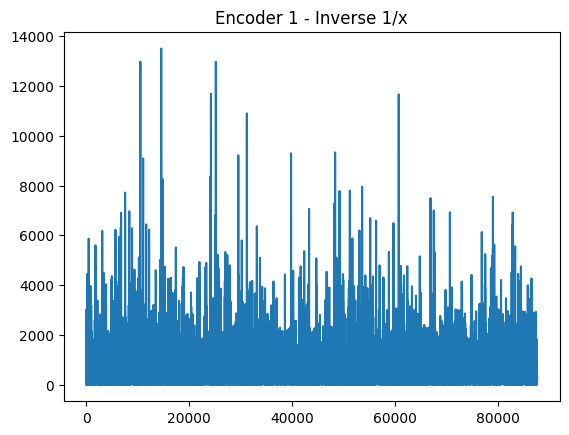

In [40]:
import matplotlib.pyplot as plt

plt.title("Encoder 1 - Inverse 1/x")
plt.plot(input_inv_1)
print(min(input_inv_1))
print(max(input_inv_1))

-15.795114321890757
14.05409623151925


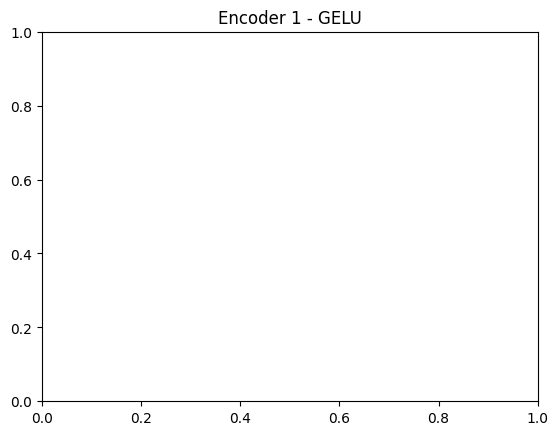

In [41]:
plt.title("Encoder 1 - GELU")
input_gelu_1 = np.array(input_gelu_1).reshape(-1)
#plt.plot(input_gelu_1)
print(min(input_gelu_1))
print(max(input_gelu_1))

0.20084548767117139
1.0902143022026484e+19


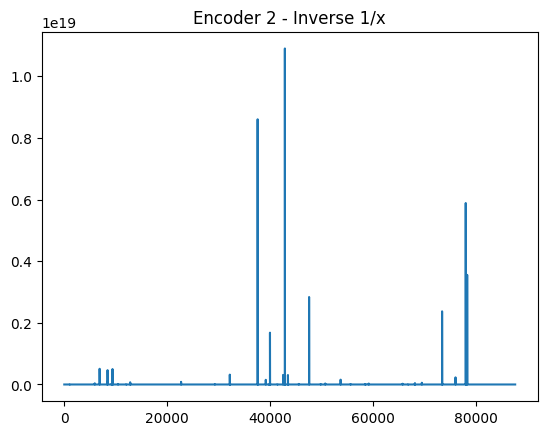

In [42]:
plt.title("Encoder 2 - Inverse 1/x")
plt.plot(input_inv_2)
print(min(input_inv_2))
print(max(input_inv_2))

-36.43114169348875
34.437743729691135


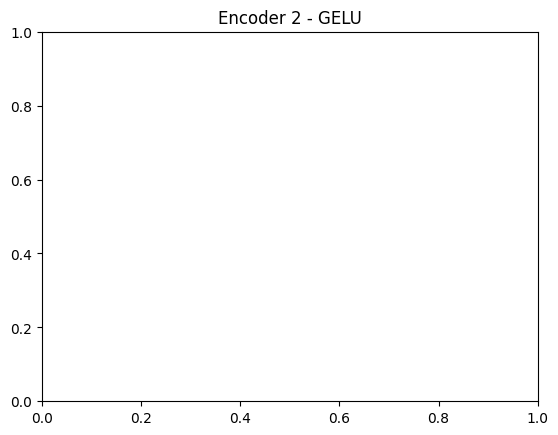

In [43]:
plt.title("Encoder 2 - GELU")
input_gelu_1 = np.array(input_gelu_2).reshape(-1)
print(min(input_gelu_2))
print(max(input_gelu_2))

-61.72339262017618
59.116059987140105


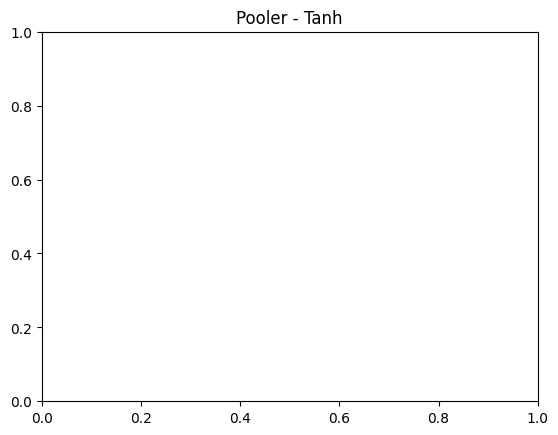

In [44]:
plt.title("Pooler - Tanh")
print(min(input_tanh))
print(max(input_tanh))